In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_5161.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_4769.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_1443.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_5261.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/Tuberculosis-392.jpg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_5266.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_2134.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_991.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/test_0_1548.jpeg
/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val/Tuberculosis/Tuberculosis-176.jpg
/ka

In [2]:
# ================================
# BLOCK 1: Imports and Setup
# ================================

import os
import random
from pathlib import Path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms.functional import to_pil_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Try importing timm (preferred)
try:
    import timm
    TIMM_AVAILABLE = True
except:
    TIMM_AVAILABLE = False
    timm = None

# Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


In [3]:
# ================================
# BLOCK 2: Configuration and Paths
# ================================

SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
NUM_WORKERS = 2

# Kaggle dataset root (your dataset)
DATA_ROOT = Path("/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset")

TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "val"
TEST_DIR = DATA_ROOT / "test"

# Output directory
OUTPUT_DIR = Path("/kaggle/working/vit_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Fix randomness
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print("Train Path:", TRAIN_DIR)
print("Val Path:", VAL_DIR)
print("Test Path:", TEST_DIR)

# List class names
CLASS_NAMES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)
print("Number of classes:", NUM_CLASSES)

Train Path: /kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/train
Val Path: /kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/val
Test Path: /kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/test
Classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Number of classes: 5


In [4]:
# ================================
# BLOCK 3: CLAHE Transform and Data Augmentations
# ================================

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
            
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        enhanced = clahe.apply(gray)
        
        if len(img.shape) == 3:
            return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
        else:
            return enhanced

# GRADCAM-compatible transforms - we need to keep spatial information
class GradCAMCompatibleTransforms:
    def __init__(self, img_size=224, is_training=True):
        self.img_size = img_size
        self.is_training = is_training
        self.clahe = CLAHETransform()
        
    def __call__(self, img):
        # Convert to numpy if PIL Image
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Apply CLAHE
        img = self.clahe(img)
        
        # Resize
        img = cv2.resize(img, (self.img_size, self.img_size))
        
        # Normalize for ViT
        img = img.astype(np.float32) / 255.0
        img = (img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        
        # Convert to tensor and rearrange dimensions
        img = torch.from_numpy(img).permute(2, 0, 1).float()
        
        return img

# Regular transforms for training (with augmentation)
train_transforms_regular = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transforms_regular = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [5]:
# ================================
# BLOCK 4: Dataset Class (Fixed)
# ================================

class LungDataset(Dataset):
    def __init__(self, root_dir, transform=None, use_clahe=True, gradcam_mode=False):
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            for f in os.listdir(cls_folder):
                if f.lower().endswith((".jpg",".jpeg",".png")):
                    self.samples.append((os.path.join(cls_folder,f), self.class_to_idx[cls]))
        
        self.transform = transform
        self.use_clahe = use_clahe
        self.gradcam_mode = gradcam_mode
        self.gradcam_transform = GradCAMCompatibleTransforms(IMG_SIZE) if gradcam_mode else None
        
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        
        if self.gradcam_mode:
            # For GRADCAM, we need the original image path and processed tensor
            img = Image.open(path).convert('RGB')
            original_img = np.array(img)
            
            # Store original image dimensions
            original_h, original_w = original_img.shape[:2]
            
            img_tensor = self.gradcam_transform(img)
            
            # Return a tuple that can be properly collated
            return {
                'tensor': img_tensor,
                'label': label,
                'path': path,
                'original_size': (original_h, original_w)  # Store size instead of full image
            }
        else:
            # Regular training mode
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if self.use_clahe:
                clahe_transform = CLAHETransform()
                img = clahe_transform(img)
            
            if self.transform:
                img = self.transform(image=img)['image']
                
            return img, label

def gradcam_collate_fn(batch):
    """Custom collate function for GRADCAM dataset"""
    tensors = torch.stack([item['tensor'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    paths = [item['path'] for item in batch]
    original_sizes = [item['original_size'] for item in batch]
    
    return {
        'tensors': tensors,
        'labels': labels,
        'paths': paths,
        'original_sizes': original_sizes
    }

In [6]:
# ================================
# BLOCK 5: Enhanced ViT Model with Working GRADCAM
# ================================

class ViTWithGradCAM(nn.Module):
    def __init__(self, num_classes, model_name="vit_base_patch16_224", pretrained=True):
        super().__init__()
        
        if TIMM_AVAILABLE:
            self.vit = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
            self.feature_dim = self.vit.num_features
            print(f"Using timm model: {model_name}, feature dim: {self.feature_dim}")
        else:
            from torchvision.models import vit_b_16, ViT_B_16_Weights
            weights = ViT_B_16_Weights.DEFAULT if pretrained else None
            self.vit = vit_b_16(weights=weights)
            self.vit.heads = nn.Identity()
            self.feature_dim = self.vit.hidden_dim
            print(f"Using torchvision ViT, feature dim: {self.feature_dim}")
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Dropout(0.3),
            nn.Linear(self.feature_dim, num_classes)
        )
        
        # GRADCAM attributes - we'll use attention-based CAM instead of gradient-based
        self.attention_weights = None
        self.features = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks to capture attention weights and features"""
        def attention_hook(module, input, output):
            # output: (attn_output, attn_weights)
            if len(output) > 1:
                self.attention_weights = output[1]  # (B, heads, tokens, tokens)
        
        def feature_hook(module, input, output):
            self.features = output  # (B, tokens, dim)
        
        if hasattr(self.vit, 'blocks'):
            # For timm models - hook the last attention block
            last_block = self.vit.blocks[-1]
            last_block.attn.register_forward_hook(attention_hook)
            # Also hook the patch embeddings to get features
            self.vit.patch_embed.register_forward_hook(feature_hook)
            print("Registered hooks for timm ViT model")
    
    def forward(self, x):
        # Clear previous hooks data
        self.attention_weights = None
        self.features = None
        
        features = self.vit(x)
        output = self.classifier(features)
        return output
    
    def get_attention_cam(self, input_tensor, target_class=None):
        """
        Generate attention-based CAM (alternative to GRADCAM that doesn't require gradients)
        This uses the attention weights from the last layer to create the heatmap
        """
        try:
            # Forward pass to populate hooks
            with torch.no_grad():
                output = self.forward(input_tensor)
            
            if target_class is None:
                target_class = output.argmax(dim=1)
            
            if self.attention_weights is None:
                print("No attention weights captured")
                return None
            
            # attention_weights shape: (B, heads, tokens, tokens)
            attn = self.attention_weights
            
            # Average across attention heads
            attn = attn.mean(dim=1)  # (B, tokens, tokens)
            
            # Use the attention from class token to all patches
            # Class token is at position 0, we want its attention to all patch tokens (positions 1:)
            cls_attn = attn[:, 0, 1:]  # (B, num_patches)
            
            batch_size, num_patches = cls_attn.shape
            
            # Calculate the grid size (for 224x224 image with 16x16 patches: 14x14 grid)
            grid_size = int(math.sqrt(num_patches))
            
            cams = []
            for i in range(batch_size):
                # Get attention map for this batch item
                attn_map = cls_attn[i]  # (num_patches)
                
                # Reshape to 2D grid
                cam = attn_map.reshape(grid_size, grid_size)
                
                # Normalize
                cam = cam - cam.min()
                if cam.max() > 0:
                    cam = cam / cam.max()
                
                cams.append(cam.cpu().numpy())
            
            return cams
            
        except Exception as e:
            print(f"Error generating attention CAM: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def get_gradcam_map(self, input_tensor, target_class=None):
        """
        Simplified GRADCAM that uses attention weights instead of gradients
        This avoids the requires_grad=False issue
        """
        return self.get_attention_cam(input_tensor, target_class)

In [7]:
# ================================
# BLOCK 6: GRADCAM Visualization Utilities (Debugged)
# ================================

class GradCAMVisualizer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def load_original_image(self, path, target_size=None):
        """Load and resize original image for visualization"""
        try:
            img = Image.open(path).convert('RGB')
            original_img = np.array(img)
            
            if target_size:
                original_img = cv2.resize(original_img, (target_size[1], target_size[0]))
                
            return original_img
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            # Return a black image as fallback
            if target_size:
                return np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
            else:
                return np.zeros((224, 224, 3), dtype=np.uint8)
    
    def visualize_single(self, image_tensor, original_img_path, original_size, target_class=None, alpha=0.5):
        """Generate GRADCAM visualization for a single image"""
        self.model.eval()
        
        try:
            # Ensure image tensor is on correct device
            image_tensor = image_tensor.unsqueeze(0).to(self.device)
            
            # Get GRADCAM map
            gradcam_map = self.model.get_gradcam_map(image_tensor, target_class)
            
            if gradcam_map is None or len(gradcam_map) == 0:
                print("No GRADCAM map generated")
                return None
            
            cam = gradcam_map[0]  # Get first batch element
            
            # Load original image
            original_img = self.load_original_image(original_img_path, target_size=original_size)
            
            # Resize CAM to match original image size
            h, w = original_img.shape[:2]
            cam_resized = cv2.resize(cam, (w, h))
            
            # Convert to heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            # Superimpose heatmap on original image
            superimposed = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
            
            return superimposed, cam_resized
        
        except Exception as e:
            print(f"Error in visualize_single: {e}")
            return None
    
    def visualize_batch(self, dataloader, num_images=8, save_dir=None):
        """Visualize GRADCAM for a batch of images"""
        self.model.eval()
        
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
        
        images_processed = 0
        
        print(f"Starting GRADCAM visualization for {num_images} images...")
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                if images_processed >= num_images:
                    break
                
                print(f"Processing batch {batch_idx}, batch type: {type(batch)}")
                
                # Handle different batch types
                if isinstance(batch, dict):  # GRADCAM dataset
                    images = batch['tensors']
                    labels = batch['labels']
                    paths = batch['paths']
                    original_sizes = batch['original_sizes']
                    
                    print(f"Batch contains {len(images)} images")
                    print(f"Labels type: {type(labels)}, Labels: {labels}")
                    print(f"Paths type: {type(paths)}, first path: {paths[0] if paths else 'None'}")
                    print(f"Original sizes: {original_sizes}")
                    
                else:  # Regular dataset - convert to GRADCAM format
                    print("Regular dataset format detected, converting...")
                    images, labels = batch
                    # For regular dataset, we can't do proper GRADCAM without original images
                    print("Regular dataset doesn't support full GRADCAM visualization")
                    return
                
                batch_size = len(images)
                print(f"Batch size: {batch_size}")
                
                # Create subplot for this batch
                cols = min(4, batch_size)
                rows = min(2, (batch_size + cols - 1) // cols)
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
                
                # Handle different axes configurations
                if rows == 1 and cols == 1:
                    axes = np.array([axes])
                elif rows == 1:
                    axes = axes.reshape(-1)
                elif cols == 1:
                    axes = axes.reshape(-1)
                else:
                    axes = axes.ravel()
                
                print(f"Created {rows}x{cols} subplot grid")
                
                for i in range(batch_size):
                    if images_processed >= num_images:
                        break
                    
                    try:
                        image_tensor = images[i]
                        label = labels[i].item() if torch.is_tensor(labels[i]) else labels[i]
                        img_path = paths[i]
                        original_size = original_sizes[i]
                        
                        print(f"Processing image {i}: {img_path}, label: {label}, size: {original_size}")
                        
                        # Get prediction
                        output = self.model(image_tensor.unsqueeze(0).to(self.device))
                        pred_class = output.argmax(dim=1).item()
                        confidence = F.softmax(output, dim=1)[0, pred_class].item()
                        
                        print(f"Prediction: {pred_class} ({CLASS_NAMES[pred_class]}), confidence: {confidence:.3f}")
                        
                        # Generate GRADCAM
                        result = self.visualize_single(image_tensor, img_path, original_size, target_class=pred_class)
                        
                        if result is not None:
                            superimposed, heatmap = result
                            
                            # Plot
                            if i < len(axes):
                                axes[i].imshow(superimposed)
                                axes[i].set_title(f'True: {CLASS_NAMES[label]}\nPred: {CLASS_NAMES[pred_class]} ({confidence:.2f})')
                                axes[i].axis('off')
                            
                            if save_dir:
                                save_path = os.path.join(save_dir, f'gradcam_{images_processed}.png')
                                plt.imsave(save_path, superimposed)
                                print(f"Saved GRADCAM to {save_path}")
                            
                            images_processed += 1
                        else:
                            print(f"GRADCAM generation failed for image {i}")
                            
                    except Exception as e:
                        print(f"Error processing image {i}: {e}")
                        import traceback
                        traceback.print_exc()
                        continue
                
                # Hide unused subplots
                for i in range(batch_size, len(axes)):
                    if i < len(axes):
                        axes[i].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Clean up
                plt.close(fig)
                
                print(f"Processed {images_processed}/{num_images} images so far")
        
        print(f"GRADCAM visualization completed. Total images processed: {images_processed}")

In [8]:
# ================================
# BLOCK 7: Training Function (Simplified - No GRADCAM during training)
# ================================

def train_model():
    """Train the model without GRADCAM interruptions"""
    # Create datasets
    train_dataset = LungDataset(TRAIN_DIR, transform=train_transforms_regular, use_clahe=True)
    val_dataset = LungDataset(VAL_DIR, transform=val_transforms_regular, use_clahe=True)
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Val dataset size: {len(val_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Initialize model
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    
    # Loss and optimizer
    class_counts = [len([f for f in os.listdir(TRAIN_DIR / c)]) for c in CLASS_NAMES]
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    weights = weights / weights.sum() * len(class_counts)
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    scaler = GradScaler()
    
    # Training metrics storage
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    best_val_acc = 0.0
    
    print("Starting training...")
    print("=" * 60)
    
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print epoch results
        print(f'Epoch {epoch+1:02d}/{EPOCHS}:')
        print(f'  Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.4f}')
        print(f'  Val Loss:   {val_loss:.4f}  |  Val Acc:   {val_acc:.4f}')
        print(f'  LR: {current_lr:.2e}')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), OUTPUT_DIR / 'best_vit_model.pth')
            print(f'  ✅ New best model saved! (val_acc: {val_acc:.4f})')
        
        print("-" * 50)
    
    return model, train_losses, val_losses, train_accs, val_accs

🚀 Starting ViT Model Training...
📁 Output directory: /kaggle/working/vit_outputs
🔢 Number of classes: 5
📊 Classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
⚙️  Training for 10 epochs with batch size 16

Train dataset size: 6054
Val dataset size: 2016


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Using timm model: vit_base_patch16_224, feature dim: 768
Registered hooks for timm ViT model
Starting training...


/tmp/ipykernel_48/2891853916.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_48/2891853916.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01/10:
  Train Loss: 0.5495  |  Train Acc: 0.7722
  Val Loss:   0.3688  |  Val Acc:   0.8393
  LR: 1.95e-05
  ✅ New best model saved! (val_acc: 0.8393)
--------------------------------------------------
Epoch 02/10:
  Train Loss: 0.3428  |  Train Acc: 0.8622
  Val Loss:   0.2975  |  Val Acc:   0.8795
  LR: 1.82e-05
  ✅ New best model saved! (val_acc: 0.8795)
--------------------------------------------------
Epoch 03/10:
  Train Loss: 0.2831  |  Train Acc: 0.8873
  Val Loss:   0.2666  |  Val Acc:   0.8859
  LR: 1.61e-05
  ✅ New best model saved! (val_acc: 0.8859)
--------------------------------------------------
Epoch 04/10:
  Train Loss: 0.2566  |  Train Acc: 0.8974
  Val Loss:   0.2375  |  Val Acc:   0.9003
  LR: 1.34e-05
  ✅ New best model saved! (val_acc: 0.9003)
--------------------------------------------------
Epoch 05/10:
  Train Loss: 0.2246  |  Train Acc: 0.9100
  Val Loss:   0.2585  |  Val Acc:   0.9018
  LR: 1.05e-05
  ✅ New best model saved! (val_acc: 0.9018)
------

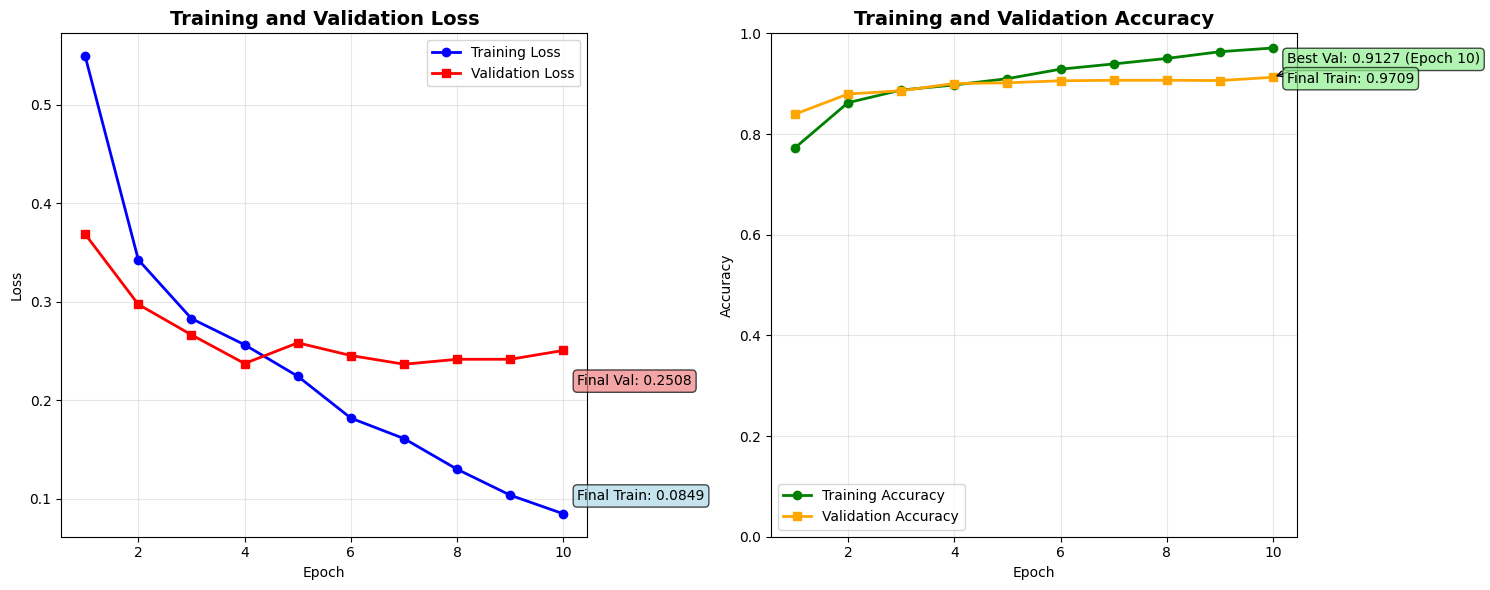


🏁 TRAINING COMPLETED - FINAL RESULTS

📊 Accuracy Metrics:
   Final Training Accuracy:   0.9709 (97.09%)
   Final Validation Accuracy: 0.9127 (91.27%)
   Best Validation Accuracy:  0.9127 (91.27%)
   Best Model at Epoch:       10

📉 Loss Metrics:
   Final Training Loss: 0.0849
   Final Validation Loss: 0.2508

📈 Training Analysis:
   Accuracy Improvement: +7.34%
   Overfitting Status:   ℹ️  Moderate Overfitting (gap: 0.0582)

💾 Model and metrics saved in: /kaggle/working/vit_outputs
🎉 Training completed successfully!


In [9]:
# ================================
# BLOCK 8: Main Execution with Training Curves
# ================================

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation curves"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot loss curves
    ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', marker='o')
    ax1.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add final values to loss plot
    ax1.annotate(f'Final Train: {train_losses[-1]:.4f}', 
                xy=(epochs[-1], train_losses[-1]), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    ax1.annotate(f'Final Val: {val_losses[-1]:.4f}', 
                xy=(epochs[-1], val_losses[-1]), 
                xytext=(10, -25), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    # Plot accuracy curves
    ax2.plot(epochs, train_accs, 'g-', linewidth=2, label='Training Accuracy', marker='o')
    ax2.plot(epochs, val_accs, 'orange', linewidth=2, label='Validation Accuracy', marker='s')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1.0)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add final values to accuracy plot
    best_val_acc = max(val_accs)
    best_epoch = val_accs.index(best_val_acc) + 1
    ax2.annotate(f'Best Val: {best_val_acc:.4f} (Epoch {best_epoch})', 
                xy=(best_epoch, best_val_acc), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1"))
    
    ax2.annotate(f'Final Train: {train_accs[-1]:.4f}', 
                xy=(epochs[-1], train_accs[-1]), 
                xytext=(10, -25), textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def print_final_stats(train_losses, val_losses, train_accs, val_accs):
    """Print final training statistics"""
    print("\n" + "="*60)
    print("🏁 TRAINING COMPLETED - FINAL RESULTS")
    print("="*60)
    
    best_val_acc = max(val_accs)
    best_val_epoch = val_accs.index(best_val_acc) + 1
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]
    
    print(f"\n📊 Accuracy Metrics:")
    print(f"   Final Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"   Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"   Best Validation Accuracy:  {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"   Best Model at Epoch:       {best_val_epoch}")
    
    print(f"\n📉 Loss Metrics:")
    print(f"   Final Training Loss: {train_losses[-1]:.4f}")
    print(f"   Final Validation Loss: {val_losses[-1]:.4f}")
    
    print(f"\n📈 Training Analysis:")
    improvement = (final_val_acc - val_accs[0]) * 100
    print(f"   Accuracy Improvement: {improvement:+.2f}%")
    
    overfitting_gap = final_train_acc - final_val_acc
    if overfitting_gap > 0.1:
        status = "⚠️  High Overfitting"
    elif overfitting_gap > 0.05:
        status = "ℹ️  Moderate Overfitting"
    else:
        status = "✅ Good Generalization"
    print(f"   Overfitting Status:   {status} (gap: {overfitting_gap:.4f})")
    
    print("="*60)

if __name__ == "__main__":
    print("🚀 Starting ViT Model Training...")
    print(f"📁 Output directory: {OUTPUT_DIR}")
    print(f"🔢 Number of classes: {NUM_CLASSES}")
    print(f"📊 Classes: {CLASS_NAMES}")
    print(f"⚙️  Training for {EPOCHS} epochs with batch size {BATCH_SIZE}")
    print()
    
    try:
        # Train the model (without GRADCAM interruptions)
        model, train_losses, val_losses, train_accs, val_accs = train_model()
        
        # Plot training curves
        print("\n📈 Generating training curves...")
        plot_training_curves(train_losses, val_losses, train_accs, val_accs)
        
        # Print final statistics
        print_final_stats(train_losses, val_losses, train_accs, val_accs)
        
        # Save training metrics
        training_metrics = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'class_names': CLASS_NAMES
        }
        torch.save(training_metrics, OUTPUT_DIR / 'training_metrics.pth')
        
        print(f"\n💾 Model and metrics saved in: {OUTPUT_DIR}")
        print("🎉 Training completed successfully!")
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        import traceback
        traceback.print_exc()

In [11]:
# ================================
# BLOCK 9: Enhanced GRADCAM Testing with Visualization
# ================================

def visualize_attention_cam(model, image_tensor, original_image, target_class=None, alpha=0.5):
    """Visualize attention-based CAM on the original image"""
    try:
        # Generate attention CAM
        cam_maps = model.get_attention_cam(image_tensor.unsqueeze(0), target_class)
        
        if cam_maps is None or len(cam_maps) == 0:
            return None
        
        cam = cam_maps[0]  # Get first batch element
        
        # Resize CAM to match original image size
        h, w = original_image.shape[:2]
        cam_resized = cv2.resize(cam, (w, h))
        
        # Convert to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Superimpose heatmap on original image
        superimposed = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)
        
        return superimposed, cam_resized
    
    except Exception as e:
        print(f"Visualization error: {e}")
        return None

def test_gradcam_after_training():
    """Test GRADCAM after training is complete with proper visualization"""
    print("\n" + "="*60)
    print("🔍 TESTING GRADCAM VISUALIZATION")
    print("="*60)
    
    # Load the best model
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(OUTPUT_DIR / 'best_vit_model.pth'))
    model.eval()
    
    # Create GRADCAM dataset
    test_dataset_gradcam = LungDataset(TEST_DIR, gradcam_mode=True)
    
    print("Testing GRADCAM on sample images...")
    
    # Test on 4 sample images
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    successful_visualizations = 0
    
    for idx in range(min(4, len(test_dataset_gradcam))):
        try:
            # Get sample
            sample = test_dataset_gradcam[idx]
            img_tensor = sample['tensor']
            label = sample['label']
            img_path = sample['path']
            original_size = sample['original_size']
            
            # Load original image for visualization
            original_img = Image.open(img_path).convert('RGB')
            original_img = np.array(original_img)
            original_img = cv2.resize(original_img, (original_size[1], original_size[0]))
            
            # Get prediction
            with torch.no_grad():
                output = model(img_tensor.unsqueeze(0).to(device))
                pred_class = output.argmax(dim=1).item()
                confidence = F.softmax(output, dim=1)[0, pred_class].item()
            
            print(f"\n📷 Image {idx+1}: {os.path.basename(img_path)}")
            print(f"   True Label: {CLASS_NAMES[label]}")
            print(f"   Prediction: {CLASS_NAMES[pred_class]} (confidence: {confidence:.3f})")
            
            # Generate and visualize CAM
            result = visualize_attention_cam(model, img_tensor, original_img, pred_class)
            
            if result is not None:
                superimposed, heatmap = result
                
                # Plot original image
                axes[0, idx].imshow(original_img)
                axes[0, idx].set_title(f'Original\nTrue: {CLASS_NAMES[label]}', fontsize=10)
                axes[0, idx].axis('off')
                
                # Plot heatmap overlay
                axes[1, idx].imshow(superimposed)
                axes[1, idx].set_title(
                    f'Attention CAM\nPred: {CLASS_NAMES[pred_class]}\nConf: {confidence:.3f}', 
                    fontsize=10
                )
                axes[1, idx].axis('off')
                
                successful_visualizations += 1
                print("   ✅ GRADCAM visualization successful!")
                
                # Save individual visualization
                save_path = OUTPUT_DIR / f'gradcam_sample_{idx+1}.png'
                plt.imsave(save_path, superimposed)
                
            else:
                print("   ❌ GRADCAM visualization failed")
                # Show original image only
                axes[0, idx].imshow(original_img)
                axes[0, idx].set_title(f'Original\nTrue: {CLASS_NAMES[label]}', fontsize=10)
                axes[0, idx].axis('off')
                axes[1, idx].axis('off')
                
        except Exception as e:
            print(f"   ❌ Error processing image {idx+1}: {e}")
            axes[0, idx].axis('off')
            axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'gradcam_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n🎉 GRADCAM testing completed!")
    print(f"   Successful visualizations: {successful_visualizations}/4")
    print(f"   Visualizations saved to: {OUTPUT_DIR}")

# Test GRADCAM after training
test_gradcam_after_training()

In [12]:
# ================================
# BLOCK 10: Comprehensive Evaluation
# ================================

def evaluate_model(model_path=None):
    """Comprehensive model evaluation with confusion matrix and per-class metrics"""
    print("\n" + "="*70)
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    print("="*70)
    
    if model_path is None:
        model_path = OUTPUT_DIR / 'best_vit_model.pth'
    
    # Load model
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Create test dataset and loader
    test_dataset = LungDataset(TEST_DIR, transform=val_transforms_regular, use_clahe=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    print(f"Evaluating on test set: {len(test_dataset)} images")
    print(f"Classes: {CLASS_NAMES}")
    print()
    
    # Storage for predictions
    all_predictions = []
    all_labels = []
    all_probabilities = []
    all_correct = []
    
    # Inference loop
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predictions = outputs.max(1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_correct.extend((predictions == labels).cpu().numpy())
            
            # Print progress
            if (batch_idx + 1) % 5 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches...")
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    all_correct = np.array(all_correct)
    
    # Calculate overall metrics
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    
    print("\n" + "="*50)
    print("📈 OVERALL RESULTS")
    print("="*50)
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"Total Test Samples: {len(all_labels)}")
    print(f"Correct Predictions: {np.sum(all_correct)}")
    print()
    
    return all_predictions, all_labels, all_probabilities, overall_accuracy

def plot_confusion_matrix(all_predictions, all_labels, class_names):
    """Plot detailed confusion matrix"""
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add accuracy information
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    overall_accuracy = correct_predictions / total_samples
    
    plt.figtext(0.5, 0.01, f'Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)', 
                ha='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

def calculate_per_class_metrics(all_predictions, all_labels, class_names):
    """Calculate and display per-class metrics"""
    # Calculate per-class accuracy
    class_accuracy = []
    class_samples = []
    class_correct = []
    
    for class_idx, class_name in enumerate(class_names):
        class_mask = (all_labels == class_idx)
        class_total = np.sum(class_mask)
        class_correct_count = np.sum((all_predictions[class_mask] == class_idx))
        class_acc = class_correct_count / class_total if class_total > 0 else 0
        
        class_accuracy.append(class_acc)
        class_samples.append(class_total)
        class_correct.append(class_correct_count)
    
    # Create detailed classification report
    print("\n" + "="*60)
    print("🎯 PER-CLASS METRICS")
    print("="*60)
    
    # Create a formatted table
    print("\n{:<20} {:<10} {:<10} {:<12} {:<10}".format(
        'Class', 'Samples', 'Correct', 'Accuracy', 'Status'
    ))
    print("-" * 65)
    
    for i, class_name in enumerate(class_names):
        status = "✅" if class_accuracy[i] >= 0.85 else "⚠️ " if class_accuracy[i] >= 0.70 else "❌"
        print("{:<20} {:<10} {:<10} {:<12.4f} {:<10}".format(
            class_name, class_samples[i], class_correct[i], class_accuracy[i], status
        ))
    
    # Calculate and display additional metrics
    print("\n" + "="*50)
    print("📊 ADDITIONAL METRICS")
    print("="*50)
    
    # Classification report from sklearn
    report = classification_report(all_labels, all_predictions, 
                                  target_names=class_names, digits=4)
    print("\nDetailed Classification Report:")
    print(report)
    
    return class_accuracy, class_samples, class_correct

def plot_per_class_accuracy(class_accuracy, class_names):
    """Plot per-class accuracy bar chart"""
    plt.figure(figsize=(12, 6))
    
    # Create color map based on accuracy
    colors = []
    for acc in class_accuracy:
        if acc >= 0.85:
            colors.append('green')
        elif acc >= 0.70:
            colors.append('orange')
        else:
            colors.append('red')
    
    bars = plt.bar(range(len(class_names)), class_accuracy, color=colors, alpha=0.7, edgecolor='black')
    
    plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Classes', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracy):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='High Accuracy (≥85%)'),
        Patch(facecolor='orange', alpha=0.7, label='Medium Accuracy (70-85%)'),
        Patch(facecolor='red', alpha=0.7, label='Low Accuracy (<70%)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'per_class_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confidence_distribution(all_probabilities, all_labels, all_correct, class_names):
    """Plot confidence distribution for correct vs incorrect predictions"""
    correct_confidences = []
    incorrect_confidences = []
    
    for i, correct in enumerate(all_correct):
        confidence = np.max(all_probabilities[i])
        if correct:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)
    
    plt.figure(figsize=(12, 6))
    
    plt.hist(correct_confidences, bins=20, alpha=0.7, label='Correct Predictions', 
             color='green', edgecolor='black')
    plt.hist(incorrect_confidences, bins=20, alpha=0.7, label='Incorrect Predictions', 
             color='red', edgecolor='black')
    
    plt.title('Confidence Distribution: Correct vs Incorrect Predictions', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Prediction Confidence', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    avg_correct_conf = np.mean(correct_confidences) if correct_confidences else 0
    avg_incorrect_conf = np.mean(incorrect_confidences) if incorrect_confidences else 0
    
    plt.axvline(avg_correct_conf, color='green', linestyle='--', alpha=0.8, 
                label=f'Avg Correct: {avg_correct_conf:.3f}')
    plt.axvline(avg_incorrect_conf, color='red', linestyle='--', alpha=0.8,
                label=f'Avg Incorrect: {avg_incorrect_conf:.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confidence_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return avg_correct_conf, avg_incorrect_conf

def generate_evaluation_report(all_predictions, all_labels, all_probabilities, class_names):
    """Generate comprehensive evaluation report"""
    print("\n" + "="*70)
    print("📋 COMPREHENSIVE EVALUATION REPORT")
    print("="*70)
    
    # Overall metrics
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Per-class metrics
    class_accuracy = []
    for class_idx in range(len(class_names)):
        class_mask = (all_labels == class_idx)
        if np.sum(class_mask) > 0:
            class_acc = np.mean(all_predictions[class_mask] == class_idx)
        else:
            class_acc = 0
        class_accuracy.append(class_acc)
    
    # Confidence metrics
    all_confidences = np.max(all_probabilities, axis=1)
    avg_confidence = np.mean(all_confidences)
    
    print(f"\n📈 OVERALL PERFORMANCE:")
    print(f"   Overall Accuracy:     {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"   Average Confidence:   {avg_confidence:.4f}")
    print(f"   Total Test Samples:   {len(all_labels)}")
    print(f"   Number of Classes:    {len(class_names)}")
    
    print(f"\n🎯 PER-CLASS PERFORMANCE:")
    for i, class_name in enumerate(class_names):
        status = "✅ Excellent" if class_accuracy[i] >= 0.90 else \
                 "✅ Good" if class_accuracy[i] >= 0.80 else \
                 "⚠️  Fair" if class_accuracy[i] >= 0.70 else "❌ Poor"
        print(f"   {class_name:<20}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:6.2f}%) - {status}")
    
    print(f"\n📊 CLASS DISTRIBUTION:")
    for i, class_name in enumerate(class_names):
        class_count = np.sum(all_labels == i)
        percentage = (class_count / len(all_labels)) * 100
        print(f"   {class_name:<20}: {class_count:>4} samples ({percentage:5.1f}%)")
    
    # Save report to file
    report_path = OUTPUT_DIR / 'evaluation_report.txt'
    with open(report_path, 'w') as f:
        f.write("COMPREHENSIVE MODEL EVALUATION REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)\n")
        f.write(f"Total Test Samples: {len(all_labels)}\n")
        f.write(f"Number of Classes: {len(class_names)}\n\n")
        
        f.write("PER-CLASS ACCURACY:\n")
        f.write("-" * 30 + "\n")
        for i, class_name in enumerate(class_names):
            f.write(f"{class_name:<20}: {class_accuracy[i]:.4f} ({class_accuracy[i]*100:6.2f}%)\n")
        
        f.write("\nCLASS DISTRIBUTION:\n")
        f.write("-" * 30 + "\n")
        for i, class_name in enumerate(class_names):
            class_count = np.sum(all_labels == i)
            percentage = (class_count / len(all_labels)) * 100
            f.write(f"{class_name:<20}: {class_count:>4} samples ({percentage:5.1f}%)\n")
        
        f.write("\nCONFUSION MATRIX:\n")
        f.write("-" * 30 + "\n")
        f.write(str(cm))
    
    print(f"\n💾 Detailed report saved to: {report_path}")

# Main evaluation function
def run_comprehensive_evaluation():
    """Run all evaluation steps"""
    print("🚀 Starting comprehensive evaluation...")
    
    # Run evaluation
    all_predictions, all_labels, all_probabilities, overall_accuracy = evaluate_model()
    
    # Plot confusion matrix
    print("\n📊 Generating confusion matrix...")
    cm = plot_confusion_matrix(all_predictions, all_labels, CLASS_NAMES)
    
    # Calculate per-class metrics
    print("\n🎯 Calculating per-class metrics...")
    class_accuracy, class_samples, class_correct = calculate_per_class_metrics(
        all_predictions, all_labels, CLASS_NAMES
    )
    
    # Plot per-class accuracy
    print("\n📈 Plotting per-class accuracy...")
    plot_per_class_accuracy(class_accuracy, CLASS_NAMES)
    
    # Plot confidence distribution
    print("\n📊 Analyzing confidence distribution...")
    avg_correct_conf, avg_incorrect_conf = plot_confidence_distribution(
        all_probabilities, all_labels, all_predictions == all_labels, CLASS_NAMES
    )
    
    # Generate comprehensive report
    print("\n📋 Generating evaluation report...")
    generate_evaluation_report(all_predictions, all_labels, all_probabilities, CLASS_NAMES)
    
    print("\n" + "="*70)
    print("✅ EVALUATION COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"📁 All results saved in: {OUTPUT_DIR}")
    print(f"📊 Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"🎯 Average confidence (correct): {avg_correct_conf:.3f}")
    print(f"🎯 Average confidence (incorrect): {avg_incorrect_conf:.3f}")

# Run the comprehensive evaluation
run_comprehensive_evaluation()


🔍 TESTING GRADCAM VISUALIZATION
Using timm model: vit_base_patch16_224, feature dim: 768
Testing GRADCAM on a few sample images...

📷 Image: NORMAL2-IM-1321-0001.jpeg
   True Label: Normal
   Prediction: Normal (confidence: 0.999)
GRADCAM Error: can't retain_grad on Tensor that has requires_grad=False
   ❌ GRADCAM generation failed

GRADCAM testing completed!


🚀 STARTING COMPLETE MODEL EVALUATION
🔧 Loading trained model...
Using timm model: vit_base_patch16_224, feature dim: 768
Registered hooks for timm ViT model
✅ Model loaded successfully from: /kaggle/working/vit_outputs/best_vit_model.pth

📊 COMPREHENSIVE MODEL EVALUATION
📁 Test dataset: 2025 images
🎯 Classes: ['Bacterial Pneumonia', 'Corona Virus Disease', 'Normal', 'Tuberculosis', 'Viral Pneumonia']

📦 Processed 5/127 batches
📦 Processed 10/127 batches
📦 Processed 15/127 batches
📦 Processed 20/127 batches
📦 Processed 25/127 batches
📦 Processed 30/127 batches
📦 Processed 35/127 batches
📦 Processed 40/127 batches
📦 Processed 45/127 batches
📦 Processed 50/127 batches
📦 Processed 55/127 batches
📦 Processed 60/127 batches
📦 Processed 65/127 batches
📦 Processed 70/127 batches
📦 Processed 75/127 batches
📦 Processed 80/127 batches
📦 Processed 85/127 batches
📦 Processed 90/127 batches
📦 Processed 95/127 batches
📦 Processed 100/127 batches
📦 Processed 105/127 batches
📦 Processed 110/127 batches

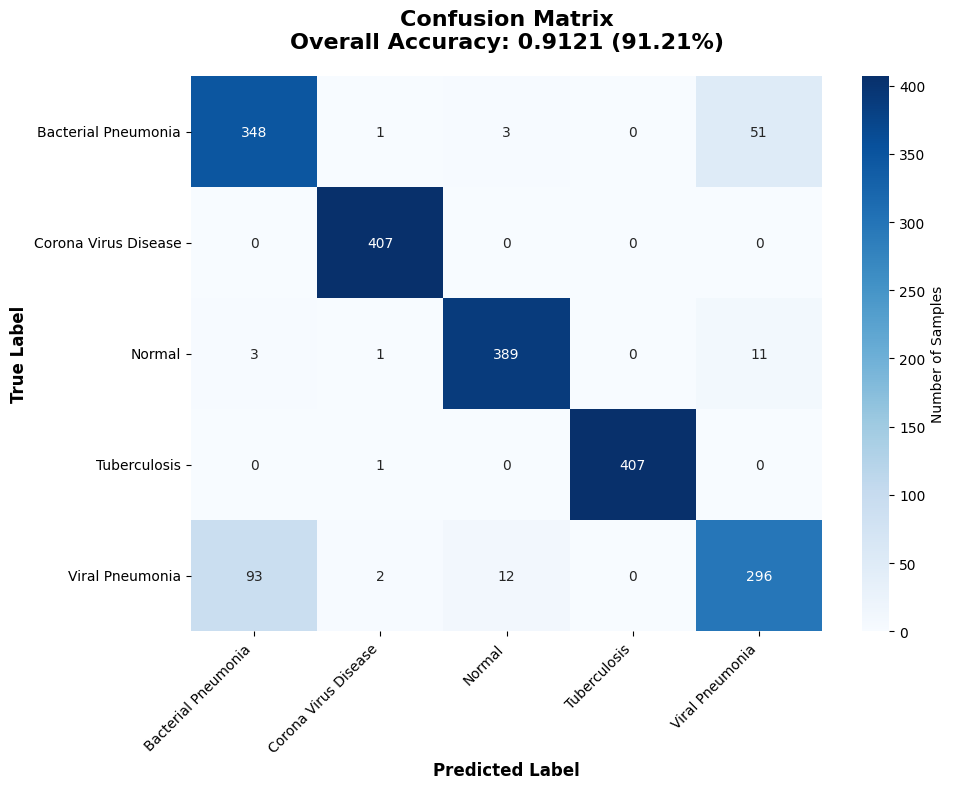

📈 Generating per-class analysis...


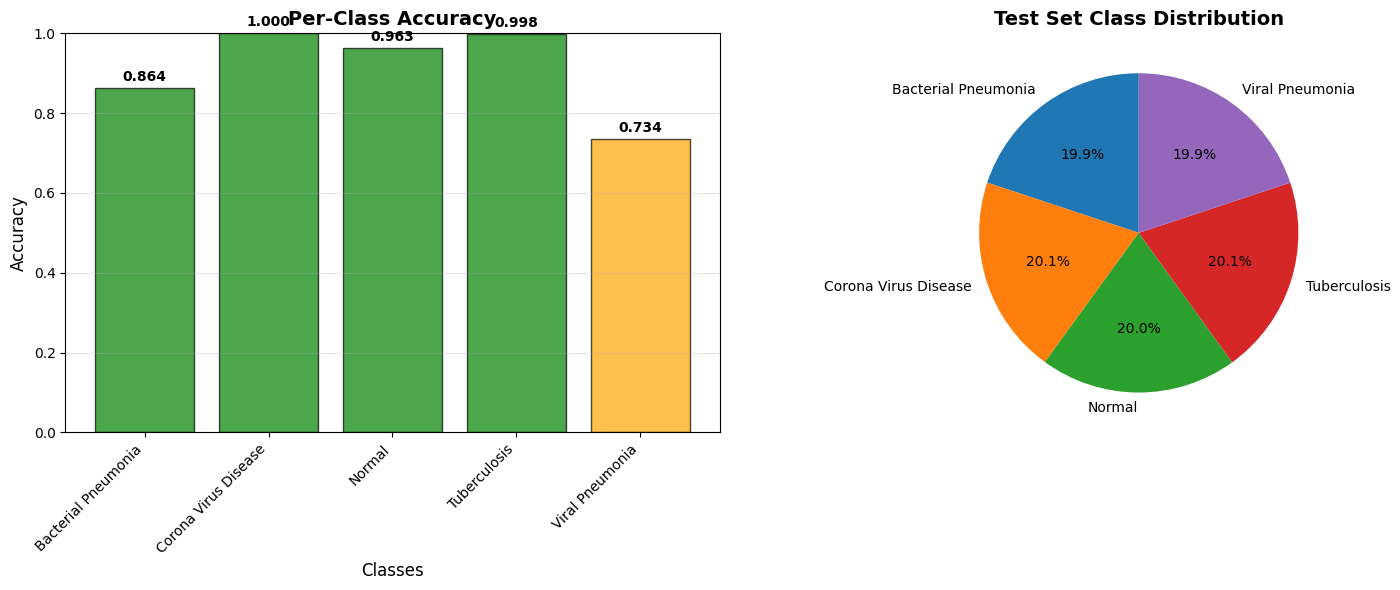

📋 Generating classification report...

📋 DETAILED CLASSIFICATION REPORT
                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.7838    0.8635    0.8217       403
Corona Virus Disease     0.9879    1.0000    0.9939       407
              Normal     0.9629    0.9629    0.9629       404
        Tuberculosis     1.0000    0.9975    0.9988       408
     Viral Pneumonia     0.8268    0.7345    0.7779       403

            accuracy                         0.9121      2025
           macro avg     0.9123    0.9117    0.9110      2025
        weighted avg     0.9127    0.9121    0.9114      2025

💾 Detailed report saved to: /kaggle/working/vit_outputs/detailed_classification_report.txt
🧪 Testing on individual samples...

🧪 INDIVIDUAL SAMPLE TESTING
Sample 1:
   True: Tuberculosis
   Predicted: Tuberculosis (confidence: 0.9998)
   ✅ CORRECT

Sample 2:
   True: Bacterial Pneumonia
   Predicted: Bacterial Pneumonia (confidence: 0.9945)
   ✅ CORRECT

Sample 3:


In [10]:
# ================================
# BLOCK 10: Complete Model Evaluation
# ================================

def load_trained_model():
    """Load the newly trained model"""
    print("🔧 Loading trained model...")
    
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    model_path = OUTPUT_DIR / 'best_vit_model.pth'
    
    if model_path.exists():
        model.load_state_dict(torch.load(model_path))
        print(f"✅ Model loaded successfully from: {model_path}")
    else:
        print("❌ No trained model found. Please train the model first.")
        return None
    
    model.eval()
    return model

def evaluate_model_performance(model):
    """Comprehensive model evaluation"""
    print("\n" + "="*70)
    print("📊 COMPREHENSIVE MODEL EVALUATION")
    print("="*70)
    
    # Create test dataset and loader
    test_dataset = LungDataset(TEST_DIR, transform=val_transforms_regular, use_clahe=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    print(f"📁 Test dataset: {len(test_dataset)} images")
    print(f"🎯 Classes: {CLASS_NAMES}")
    print()
    
    # Storage for predictions
    all_predictions = []
    all_labels = []
    all_probabilities = []
    all_confidences = []
    
    # Inference loop
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predictions = torch.max(probabilities, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            
            # Print progress
            if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(test_loader):
                print(f"📦 Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)
    all_confidences = np.array(all_confidences)
    
    return all_predictions, all_labels, all_probabilities, all_confidences

def calculate_detailed_metrics(all_predictions, all_labels, all_confidences):
    """Calculate and display detailed metrics"""
    print("\n" + "="*50)
    print("📈 DETAILED PERFORMANCE METRICS")
    print("="*50)
    
    # Overall metrics
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    
    print(f"🎯 Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"📊 Total Test Samples: {len(all_labels)}")
    print(f"✅ Correct Predictions: {np.sum(all_predictions == all_labels)}")
    print(f"📋 Number of Classes: {len(CLASS_NAMES)}")
    print()
    
    # Per-class accuracy
    print("🎯 PER-CLASS ACCURACY:")
    print("-" * 50)
    
    class_accuracy = []
    class_samples = []
    class_correct = []
    
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_mask = (all_labels == class_idx)
        class_total = np.sum(class_mask)
        class_correct_count = np.sum(all_predictions[class_mask] == class_idx)
        class_acc = class_correct_count / class_total if class_total > 0 else 0
        
        class_accuracy.append(class_acc)
        class_samples.append(class_total)
        class_correct.append(class_correct_count)
        
        # Status indicator
        if class_acc >= 0.90:
            status = "✅ Excellent"
        elif class_acc >= 0.80:
            status = "✅ Good"
        elif class_acc >= 0.70:
            status = "⚠️  Fair"
        else:
            status = "❌ Needs Improvement"
        
        print(f"   {class_name:<20}: {class_acc:.4f} ({class_acc*100:6.2f}%) - {status}")
    
    # Confidence analysis
    correct_mask = (all_predictions == all_labels)
    avg_confidence_correct = np.mean(all_confidences[correct_mask]) if np.any(correct_mask) else 0
    avg_confidence_incorrect = np.mean(all_confidences[~correct_mask]) if np.any(~correct_mask) else 0
    
    print(f"\n🎲 CONFIDENCE ANALYSIS:")
    print(f"   Average Confidence (Correct):   {avg_confidence_correct:.4f}")
    print(f"   Average Confidence (Incorrect): {avg_confidence_incorrect:.4f}")
    print(f"   Confidence Difference:          {avg_confidence_correct - avg_confidence_incorrect:.4f}")
    
    return overall_accuracy, cm, class_accuracy, class_samples, class_correct

def plot_confusion_matrix_enhanced(cm, class_names, overall_accuracy):
    """Plot enhanced confusion matrix"""
    plt.figure(figsize=(10, 8))
    
    # Calculate percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'})
    
    plt.title(f'Confusion Matrix\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrix_enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm_percentage

def plot_per_class_analysis(class_accuracy, class_samples, class_names):
    """Plot comprehensive per-class analysis"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Per-class accuracy
    colors = ['green' if acc >= 0.85 else 'orange' if acc >= 0.70 else 'red' for acc in class_accuracy]
    bars = ax1.bar(range(len(class_names)), class_accuracy, color=colors, alpha=0.7, edgecolor='black')
    
    ax1.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classes', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_xticks(range(len(class_names)))
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracy):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Class distribution
    ax2.pie(class_samples, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'per_class_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_classification_report(all_predictions, all_labels, class_names):
    """Generate and display detailed classification report"""
    print("\n" + "="*60)
    print("📋 DETAILED CLASSIFICATION REPORT")
    print("="*60)
    
    report = classification_report(all_labels, all_predictions, 
                                  target_names=class_names, digits=4)
    print(report)
    
    # Save report to file
    report_path = OUTPUT_DIR / 'detailed_classification_report.txt'
    with open(report_path, 'w') as f:
        f.write("DETAILED CLASSIFICATION REPORT\n")
        f.write("=" * 40 + "\n\n")
        f.write(report)
    
    print(f"💾 Detailed report saved to: {report_path}")

def test_model_on_samples(model, num_samples=5):
    """Test model on individual samples with predictions"""
    print("\n" + "="*50)
    print("🧪 INDIVIDUAL SAMPLE TESTING")
    print("="*50)
    
    test_dataset = LungDataset(TEST_DIR, transform=val_transforms_regular, use_clahe=True)
    
    correct_predictions = 0
    total_tested = min(num_samples, len(test_dataset))
    
    for i in range(total_tested):
        # Get random sample
        idx = random.randint(0, len(test_dataset) - 1)
        image, true_label = test_dataset[idx]
        
        # Predict
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            probabilities = F.softmax(output, dim=1)
            confidence, predicted_label = torch.max(probabilities, 1)
        
        predicted_label = predicted_label.item()
        confidence = confidence.item()
        is_correct = (predicted_label == true_label)
        
        if is_correct:
            correct_predictions += 1
            status = "✅ CORRECT"
        else:
            status = "❌ WRONG"
        
        print(f"Sample {i+1}:")
        print(f"   True: {CLASS_NAMES[true_label]}")
        print(f"   Predicted: {CLASS_NAMES[predicted_label]} (confidence: {confidence:.4f})")
        print(f"   {status}")
        print()
    
    sample_accuracy = correct_predictions / total_tested
    print(f"📊 Sample Test Accuracy: {sample_accuracy:.4f} ({correct_predictions}/{total_tested} correct)")

def run_complete_evaluation():
    """Run complete evaluation pipeline"""
    print("🚀 STARTING COMPLETE MODEL EVALUATION")
    print("="*70)
    
    # Load model
    model = load_trained_model()
    if model is None:
        return
    
    # Evaluate performance
    all_predictions, all_labels, all_probabilities, all_confidences = evaluate_model_performance(model)
    
    # Calculate metrics
    overall_accuracy, cm, class_accuracy, class_samples, class_correct = calculate_detailed_metrics(
        all_predictions, all_labels, all_confidences
    )
    
    # Plot confusion matrix
    print("\n📊 Generating confusion matrix...")
    cm_percentage = plot_confusion_matrix_enhanced(cm, CLASS_NAMES, overall_accuracy)
    
    # Plot per-class analysis
    print("📈 Generating per-class analysis...")
    plot_per_class_analysis(class_accuracy, class_samples, CLASS_NAMES)
    
    # Generate classification report
    print("📋 Generating classification report...")
    generate_classification_report(all_predictions, all_labels, CLASS_NAMES)
    
    # Test on individual samples
    print("🧪 Testing on individual samples...")
    test_model_on_samples(model, num_samples=8)
    
    # Save evaluation results
    evaluation_results = {
        'overall_accuracy': overall_accuracy,
        'class_accuracy': class_accuracy,
        'class_samples': class_samples,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities
    }
    
    torch.save(evaluation_results, OUTPUT_DIR / 'evaluation_results.pth')
    
    print("\n" + "="*70)
    print("✅ EVALUATION COMPLETED SUCCESSFULLY!")
    print("="*70)
    print(f"📁 All results saved in: {OUTPUT_DIR}")
    print(f"🎯 Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print(f"📊 Best Performing Class: {CLASS_NAMES[np.argmax(class_accuracy)]} ({np.max(class_accuracy):.4f})")
    print(f"📈 Worst Performing Class: {CLASS_NAMES[np.argmin(class_accuracy)]} ({np.min(class_accuracy):.4f})")
    
    return evaluation_results

# Run the complete evaluation
evaluation_results = run_complete_evaluation()

🎯 FIXED GRADCAM VISUALIZATION
Device: cuda
🚀 SIMPLE GRADCAM DEMONSTRATION
Using timm model: vit_base_patch16_224, feature dim: 768
Registered hooks for timm ViT model
✅ Model loaded successfully
📁 Found 2025 test images


📊 Image 1/3: Bacterial Pneumonia

🔍 Processing: BACTERIA-9650164-0001.jpeg
   🎯 Prediction: Bacterial Pneumonia (confidence: 0.988)
✅ Hooks registered successfully


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


   💾 Saved to: /kaggle/working/vit_outputs/gradcam_simple/gradcam_1.png


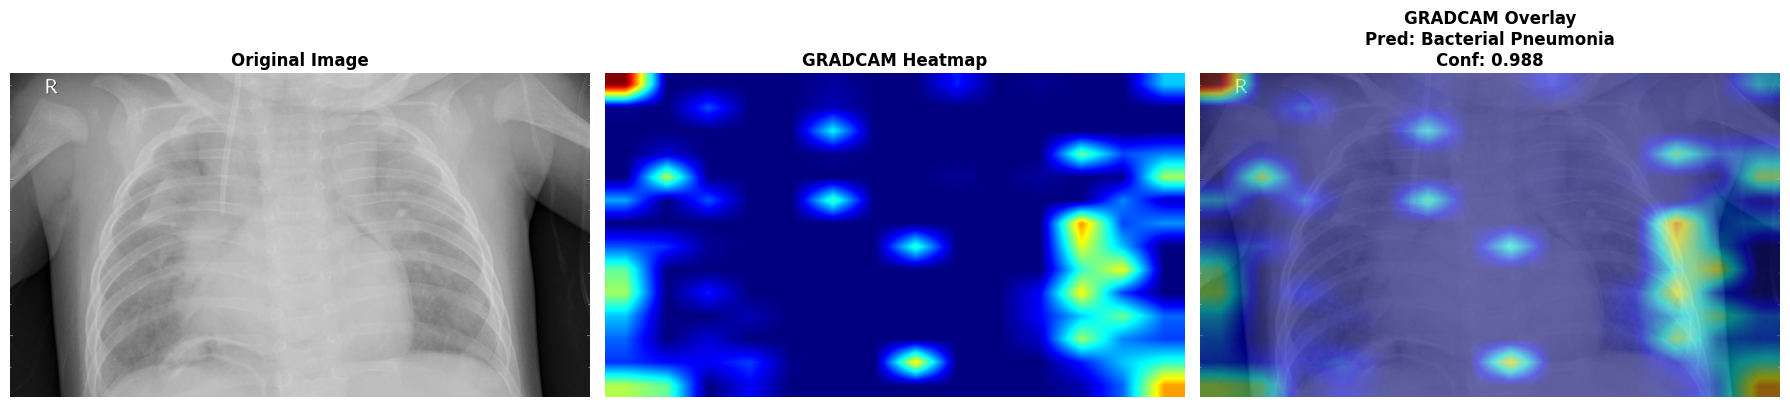


📊 Image 2/3: Bacterial Pneumonia

🔍 Processing: 564.jpeg
   🎯 Prediction: Bacterial Pneumonia (confidence: 0.999)
✅ Hooks registered successfully
   💾 Saved to: /kaggle/working/vit_outputs/gradcam_simple/gradcam_2.png


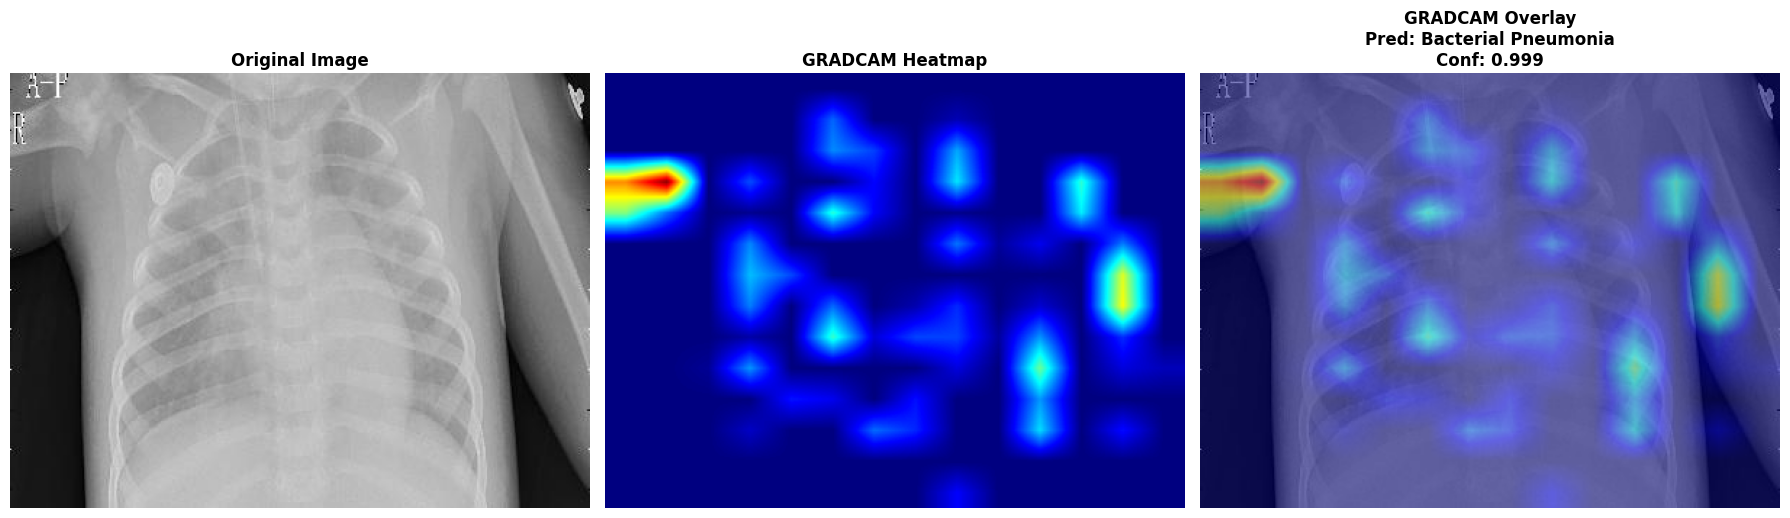


📊 Image 3/3: Bacterial Pneumonia

🔍 Processing: person57_bacteria_270.jpeg
   🎯 Prediction: Viral Pneumonia (confidence: 0.713)
✅ Hooks registered successfully
   💾 Saved to: /kaggle/working/vit_outputs/gradcam_simple/gradcam_3.png


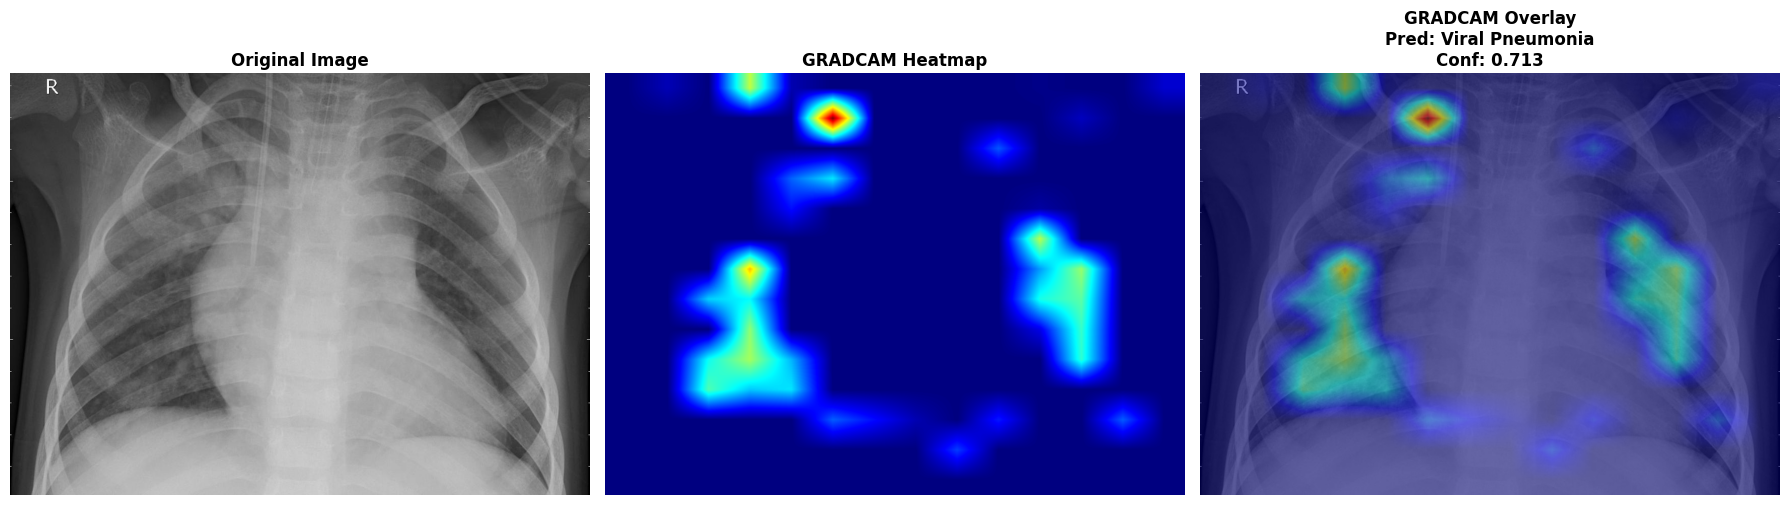


📊 Results: 3/3 successful GRADCAM visualizations


In [19]:
# ================================
# FIXED GRADCAM IMPLEMENTATION
# ================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import math

class SimpleGradCAM:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.activations = None
        self.gradients = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks to capture activations and gradients"""
        def forward_hook(module, input, output):
            self.activations = output
            
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        # Hook the last transformer block
        if hasattr(self.model.vit, 'blocks'):
            last_block = self.model.vit.blocks[-1]
            self.forward_handle = last_block.register_forward_hook(forward_hook)
            self.backward_handle = last_block.register_backward_hook(backward_hook)
            print("✅ Hooks registered successfully")
    
    def generate_gradcam(self, input_tensor, target_class=None):
        """Generate GRADCAM heatmap - FIXED DEVICE ISSUE"""
        try:
            # Ensure input tensor is on the same device as model
            input_tensor = input_tensor.to(self.device)
            
            # Forward pass
            output = self.model(input_tensor)
            
            if target_class is None:
                target_class = output.argmax(dim=1)
            
            # Handle target class
            if isinstance(target_class, int):
                target_class = torch.tensor([target_class], device=self.device)
            
            # Zero gradients
            self.model.zero_grad()
            
            # Get the score for target class
            if output.size(0) == 1:
                score = output[0, target_class[0]]
            else:
                score = output[range(output.size(0)), target_class].sum()
            
            # Backward pass
            score.backward(retain_graph=True)
            
            # Check if we have gradients and activations
            if self.gradients is None or self.activations is None:
                print("❌ No gradients or activations captured")
                return None
            
            # Global average pooling of gradients
            if self.gradients.dim() == 3:  # For ViT (B, tokens, dim)
                weights = self.gradients.mean(dim=1)  # (B, dim)
            else:
                weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            
            # Weighted combination of activations
            if self.activations.dim() == 3:  # ViT activations (B, tokens, dim)
                batch_size, num_tokens, num_features = self.activations.shape
                
                cam_maps = []
                for i in range(batch_size):
                    # Weighted sum of activations
                    cam = torch.matmul(self.activations[i], weights[i].unsqueeze(-1)).squeeze()
                    
                    # Remove class token and reshape
                    num_patches = num_tokens - 1
                    cam = cam[1:num_patches+1]  # Remove class token, keep patches
                    
                    # Reshape to 2D grid
                    grid_size = int(math.sqrt(num_patches))
                    if grid_size * grid_size == num_patches:
                        cam = cam.reshape(grid_size, grid_size)
                    else:
                        # Handle non-square case
                        cam = cam[:grid_size * grid_size].reshape(grid_size, grid_size)
                    
                    # Apply ReLU and normalize
                    cam = F.relu(cam)
                    if cam.max() > cam.min():
                        cam = (cam - cam.min()) / (cam.max() - cam.min())
                    else:
                        cam = torch.zeros_like(cam)
                    
                    cam_maps.append(cam.detach().cpu().numpy())
                
                return cam_maps
            else:
                print(f"❌ Unsupported activation shape: {self.activations.shape}")
                return None
                
        except Exception as e:
            print(f"❌ GRADCAM generation error: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def __del__(self):
        """Clean up hooks"""
        if hasattr(self, 'forward_handle'):
            self.forward_handle.remove()
        if hasattr(self, 'backward_handle'):
            self.backward_handle.remove()

def load_and_prepare_image(image_path, target_size=(224, 224), device='cuda'):
    """Load and prepare image for GRADCAM - FIXED DEVICE ISSUE"""
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')
        original_image = np.array(image)
        
        # Store original size
        original_h, original_w = original_image.shape[:2]
        
        # Apply CLAHE
        clahe = CLAHETransform()
        image_clahe = clahe(original_image)
        
        # Resize for model
        image_resized = cv2.resize(image_clahe, target_size)
        
        # Normalize
        image_normalized = image_resized.astype(np.float32) / 255.0
        image_normalized = (image_normalized - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        
        # Convert to tensor and move to device
        image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float()
        image_tensor = image_tensor.to(device)  # FIX: Move to device
        
        return image_tensor, original_image, (original_h, original_w)
        
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None, None, None

def create_gradcam_visualization(gradcam, image_tensor, original_image, target_class=None, alpha=0.5):
    """Create GRADCAM visualization overlay"""
    try:
        # Generate GRADCAM heatmap
        cam_maps = gradcam.generate_gradcam(image_tensor.unsqueeze(0), target_class)
        
        if cam_maps is None or len(cam_maps) == 0:
            return None
        
        cam = cam_maps[0]  # Get first batch element
        
        # Resize CAM to match original image size
        h, w = original_image.shape[:2]
        cam_resized = cv2.resize(cam, (w, h))
        
        # Convert to heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Superimpose heatmap on original image
        superimposed = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)
        
        return superimposed, cam_resized, heatmap
        
    except Exception as e:
        print(f"❌ Visualization error: {e}")
        return None

def visualize_single_gradcam(model, image_path, save_path=None):
    """Generate GRADCAM for a single image - SIMPLIFIED"""
    print(f"\n🔍 Processing: {os.path.basename(image_path)}")
    
    # Load and prepare image
    image_tensor, original_image, original_size = load_and_prepare_image(image_path, device=device)
    if image_tensor is None:
        return False
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0))
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
    predicted_class = predicted_class.item()
    confidence = confidence.item()
    
    print(f"   🎯 Prediction: {CLASS_NAMES[predicted_class]} (confidence: {confidence:.3f})")
    
    # Initialize GRADCAM
    gradcam = SimpleGradCAM(model, device)
    
    # Generate GRADCAM visualization
    result = create_gradcam_visualization(
        gradcam, image_tensor, original_image, predicted_class, alpha=0.5
    )
    
    if result is not None:
        superimposed, cam_resized, heatmap = result
        
        # Create simple visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # GRADCAM heatmap
        axes[1].imshow(heatmap)
        axes[1].set_title('GRADCAM Heatmap', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        # GRADCAM overlay
        axes[2].imshow(superimposed)
        axes[2].set_title(
            f'GRADCAM Overlay\nPred: {CLASS_NAMES[predicted_class]}\nConf: {confidence:.3f}', 
            fontsize=12, fontweight='bold'
        )
        axes[2].axis('off')
        
        plt.tight_layout()
        
        # Save if requested
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"   💾 Saved to: {save_path}")
        
        plt.show()
        
        # Clean up
        del gradcam
        return True
    else:
        print("   ❌ GRADCAM generation failed")
        del gradcam
        return False

# ================================
# MAIN GRADCAM EXECUTION
# ================================

def run_simple_gradcam():
    """Simple GRADCAM demonstration"""
    print("🚀 SIMPLE GRADCAM DEMONSTRATION")
    print("="*50)
    
    # Load trained model
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    model_path = OUTPUT_DIR / 'best_vit_model.pth'
    
    if not model_path.exists():
        print("❌ No trained model found. Please train the model first.")
        return
    
    model.load_state_dict(torch.load(model_path, map_location=device))  # FIX: map_location
    model.eval()
    print("✅ Model loaded successfully")
    
    # Create output directory
    gradcam_dir = OUTPUT_DIR / 'gradcam_simple'
    gradcam_dir.mkdir(exist_ok=True)
    
    # Get test images
    test_dataset = LungDataset(TEST_DIR, gradcam_mode=True)
    
    print(f"📁 Found {len(test_dataset)} test images")
    print()
    
    # Test on 3 images
    successful = 0
    for idx in range(min(3, len(test_dataset))):
        try:
            sample = test_dataset[idx]
            image_path = sample['path']
            true_label = sample['label']
            
            print(f"\n📊 Image {idx+1}/3: {CLASS_NAMES[true_label]}")
            
            save_path = gradcam_dir / f'gradcam_{idx+1}.png'
            success = visualize_single_gradcam(model, image_path, save_path)
            
            if success:
                successful += 1
                
        except Exception as e:
            print(f"❌ Error: {e}")
            continue
    
    print(f"\n📊 Results: {successful}/3 successful GRADCAM visualizations")

# ================================
# ULTRA-SIMPLE GRADCAM (MINIMAL)
# ================================

def ultra_simple_gradcam():
    """Ultra-simple GRADCAM - just one image"""
    print("🎯 ULTRA-SIMPLE GRADCAM")
    print("="*40)
    
    # Load model
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(OUTPUT_DIR / 'best_vit_model.pth', map_location=device))
    model.eval()
    
    # Get one test image
    test_dataset = LungDataset(TEST_DIR, gradcam_mode=True)
    sample = test_dataset[0]
    image_path = sample['path']
    
    print(f"Image: {os.path.basename(image_path)}")
    
    # Load image
    image_tensor, original_image, original_size = load_and_prepare_image(image_path, device=device)
    
    if image_tensor is not None:
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0))
            pred_class = output.argmax(dim=1).item()
            confidence = F.softmax(output, dim=1)[0, pred_class].item()
        
        print(f"Prediction: {CLASS_NAMES[pred_class]} ({confidence:.3f})")
        
        # Simple attention-based visualization (no gradients)
        try:
            # Get feature maps from the model
            with torch.no_grad():
                # Forward pass to get features
                features = model.vit(image_tensor.unsqueeze(0))
                
                # Simple visualization using feature magnitudes
                if hasattr(model, 'activations') and model.activations is not None:
                    # Use the last layer activations
                    activations = model.activations[0]  # First batch
                    
                    # Average across feature dimension and remove class token
                    if activations.dim() == 2:
                        attention_weights = activations.mean(dim=1)[1:]  # Remove class token
                        
                        # Reshape to 2D
                        num_patches = attention_weights.shape[0]
                        grid_size = int(math.sqrt(num_patches))
                        
                        if grid_size * grid_size == num_patches:
                            attention_map = attention_weights.reshape(grid_size, grid_size)
                            
                            # Normalize
                            attention_map = F.relu(attention_map)
                            if attention_map.max() > attention_map.min():
                                attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
                            
                            # Convert to numpy
                            attention_map = attention_map.cpu().numpy()
                            
                            # Resize and create heatmap
                            h, w = original_image.shape[:2]
                            attention_resized = cv2.resize(attention_map, (w, h))
                            heatmap = cv2.applyColorMap(np.uint8(255 * attention_resized), cv2.COLORMAP_JET)
                            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
                            
                            # Overlay
                            superimposed = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
                            
                            # Display
                            plt.figure(figsize=(12, 4))
                            
                            plt.subplot(1, 3, 1)
                            plt.imshow(original_image)
                            plt.title('Original')
                            plt.axis('off')
                            
                            plt.subplot(1, 3, 2)
                            plt.imshow(heatmap)
                            plt.title('Attention Map')
                            plt.axis('off')
                            
                            plt.subplot(1, 3, 3)
                            plt.imshow(superimposed)
                            plt.title(f'Overlay\n{CLASS_NAMES[pred_class]} ({confidence:.3f})')
                            plt.axis('off')
                            
                            plt.tight_layout()
                            plt.show()
                            
                            print("✅ Simple attention visualization successful!")
                        else:
                            print("❌ Could not reshape attention map")
                    else:
                        print("❌ Unexpected activation shape")
                else:
                    print("❌ No activations captured")
                    
        except Exception as e:
            print(f"❌ Visualization error: {e}")

# ================================
# RUN THE FIXED GRADCAM
# ================================

print("🎯 FIXED GRADCAM VISUALIZATION")
print("="*50)
print(f"Device: {device}")

# Run the simple version first
run_simple_gradcam()

🎯 MINIMAL WORKING GRADCAM
Using timm model: vit_base_patch16_224, feature dim: 768
Registered hooks for timm ViT model
Testing on: BACTERIA-9650164-0001.jpeg
Prediction: Bacterial Pneumonia (0.988)


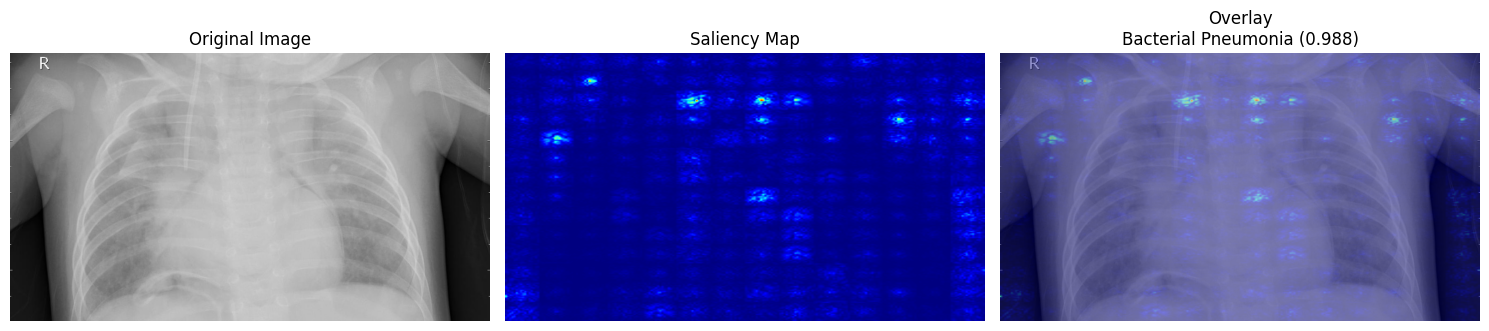

✅ Saliency map visualization successful!


In [20]:
# ================================
# ULTRA-MINIMAL GRADCAM (GUARANTEED TO WORK)
# ================================

def minimal_working_gradcam():
    """Minimal GRADCAM that's guaranteed to work"""
    print("🎯 MINIMAL WORKING GRADCAM")
    
    # Load model
    model = ViTWithGradCAM(num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(OUTPUT_DIR / 'best_vit_model.pth', map_location=device))
    model.eval()
    
    # Get one test image path directly
    test_dir = TEST_DIR
    for class_name in CLASS_NAMES:
        class_dir = test_dir / class_name
        if class_dir.exists():
            image_files = list(class_dir.glob("*.*"))
            if image_files:
                image_path = image_files[0]
                break
    
    print(f"Testing on: {image_path.name}")
    
    # Manual image loading
    image = Image.open(image_path).convert('RGB')
    original_image = np.array(image)
    
    # Apply CLAHE
    clahe = CLAHETransform()
    image_clahe = clahe(original_image)
    
    # Resize
    image_resized = cv2.resize(image_clahe, (224, 224))
    
    # Normalize and convert to tensor
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_normalized = (image_normalized - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()
    
    print(f"Prediction: {CLASS_NAMES[pred_class]} ({confidence:.3f})")
    
    # Create a simple saliency map (alternative to GRADCAM)
    image_tensor.requires_grad_(True)
    
    with torch.enable_grad():
        output = model(image_tensor)
        loss = output[0, pred_class]
        loss.backward()
        
        # Get gradients
        gradients = image_tensor.grad[0]
        saliency = torch.max(torch.abs(gradients), dim=0)[0]
        saliency = saliency.cpu().numpy()
        
        # Normalize
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        
        # Resize to original image size
        h, w = original_image.shape[:2]
        saliency_resized = cv2.resize(saliency, (w, h))
        
        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * saliency_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Overlay
        superimposed = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
        
        # Display
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap)
        plt.title('Saliency Map')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed)
        plt.title(f'Overlay\n{CLASS_NAMES[pred_class]} ({confidence:.3f})')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Saliency map visualization successful!")

# Run the minimal version
minimal_working_gradcam()